# Arbre de décision 

Après avoir utilisé les algorithmes K-NN et One Class SVM, nous avons choisi d'étudier le comportement des données face à un arbre de décision. Le principe de l'arbre de décision est d'établir une suite d'hypothèses qui vont permettre de classifier les données. L'arbre de décision est donc un algorithme d'apprentissage supervisé. Nous avons utilisé scikit-learn.tree qui construit l'arbre selon l'algorithme CART. Nous nous sommes peu intéressés à l'implémentation de l'algorithme CART afin de nous concentrer sur l'étude des divers paramètres entrant en jeu dans l'élaboration d'un modèle de Machine Learning avec les arbres de décisions.

In [1]:
from sklearn import tree
from main import *
from tools import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# On fixe le germe aléatoire
np.random.seed(2)

## Importation des données

In [2]:
X, Y, x_train, x_test, y_train, y_test = import_datas_cardfraud(sampling=1)
features = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount"]

Import des données Credit Card Fraud Detection...
Avant sampling :
Nombre de données positive : 284315
Nombre de données négatives : 492
Pourcentage négative sur positive : 0.17304750013189596%
Après sampling :
Nombre de données positive : 284315
Nombre de données négatives : 492
Pourcentage négative sur positive : 0.17304750013189596%


## Arbre de décisions dans le cas général

In [3]:
# Définition et entraînement de l'arbre
weight={+1:1,-1:1}
clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=None,random_state=1,class_weight=weight)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

# Statistiques
print_stat(y_test,y_pred)
is_leaves = clf.tree_.children_left == -1
impurity = np.dot(is_leaves, clf.tree_.impurity)
depth_tree = clf.tree_.max_depth
print("Profondeur de l'arbre : %d" %depth_tree)
print("Nombre de feuilles: %d" %np.sum(is_leaves))
print("Impuretés des feuilles: %.2f" %impurity)
print("Accuracy : %.4f" %clf.score(x_test,y_test))
print("Nombre de données négatives dans x_test: %d" %np.sum(y_test==-1))


 	 Prédit 1 	 Prédit -1
Vrai 1 	 142107 		 56
Vrai -1  63 		 178


Specifity: 0.7386
Sensivity: 0.9996
Profondeur de l'arbre : 25
Nombre de feuilles: 96
Impuretés des feuilles: 0.00
Accuracy : 0.9992
Nombre de données négatives dans x_test: 241


In [ ]:
# Sauvegarde du fichier pour la visualisation de l'arbre
# Pour visualiser l'arbre de décision généré, on pourra se rendre sur www.webgraphviz.com et copier les données de tree.dot 
# à l'endroit prévu.

with open("tree.dot", "w") as f:
        tree.export_graphviz(clf, out_file=f,feature_names=features,rounded=True,filled=False)

## Etude des différents paramètres pour l'amélioration des performances

Si le principe de l'arbre de décision est relativement simple, de nombreux paramètres sont à prendre en compte lors de l'élaboration de tels modèles. Chaque paramètre va avoir une influence sur les performances du modèle. Le premier paramètre du modèle est le germe aléatoire, que nous avons fixé dès le début. En effet, afin de pouvoir comparer les résultats, il est nécessaire de fixer ce germe.

### Etude de la profondeur de l'arbre
Ce paramètre, fixé par max_depth lors de la définition de l'arbre de décision, joue un rôle déterminant, notamment lors de la réduction de l'overfitting. En effet, lorsqu'aucune valeur n'est rentrée, scikit-learn détermine la profondeur maximale de l'arbre. Si cela permet d'avoir une impureté résiduelle dans l'arbre nulle (car chaque feuille ne contient que des données de même label), cela détermine un modèle qui colle parfaitement aux données d'entraînement mais peu aux données test : c'est un cas d'overfitting. Pour réduire ce phénomène, on peut réduire la profondeur de l'arbre en la fixant dès le début. On s'attache par la suite à déterminer la profondeur optimale de l'arbre.

In [4]:
depth_tree = range(1,depth_tree+1)
score_tp,score_tn,score_fn,score_fp = [],[],[],[]
list_impurity,sens,spec = [],[],[]

for depth in depth_tree:
    print(depth,'..',end='')
    # Définition de l'arbre
    clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=depth,random_state=1)

    # Entraînement de l'arbre
    clf.fit(x_train,y_train)

    # Prédiction
    y_pred = clf.predict(x_test)

    sensivity,specifity,_,_,_ = stat_learning(y_test,y_pred)
    sens.append(sensivity)
    spec.append(specifity)

    tp,tn,fp,fn = mat_confusion(y_test,y_pred)
    is_leaves = clf.tree_.children_left == -1
    impurity = np.dot(is_leaves, clf.tree_.impurity)

    score_tp.append(tp)
    score_tn.append(tn)
    score_fp.append(fp)
    score_fn.append(fn)
    list_impurity.append(impurity)

1 ..2 ..3 ..4 ..5 ..6 ..7 ..8 ..9 ..10 ..11 ..12 ..13 ..14 ..15 ..16 ..17 ..18 ..19 ..20 ..21 ..22 ..23 ..24 ..25 ..

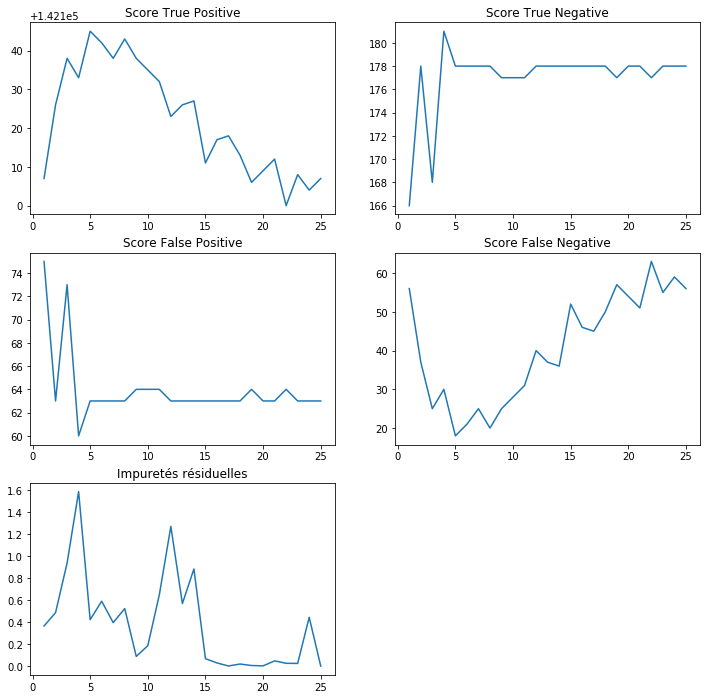

In [5]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.title("Score True Positive")
plt.plot(list(depth_tree),score_tp)
plt.subplot(3,2,2)
plt.title("Score True Negative")
plt.plot(list(depth_tree),score_tn)
plt.subplot(3,2,3)
plt.title("Score False Positive")
plt.plot(list(depth_tree),score_fp)
plt.subplot(3,2,4)
plt.title("Score False Negative")
plt.plot(list(depth_tree),score_fn)
plt.subplot(3,2,5)
plt.title("Impuretés résiduelles")
plt.plot(list(depth_tree),list_impurity)

plt.show()

L'étude des divers indicateurs de performances permettent de conclure qu'une profondeur d'arbre de 5 induit des meilleurs résultats. En effet, on cherche à maximiser le nombre de true_positive et true_negative, tout en minimisant le nombre de false_positive ou false_negative. Par la suite, c'est cette valeur qui sera utilisé.

### Etude de la prise en compte de poids sur les labels

Dans la détection d'anomalie, une erreur de prévision peut avoir un impact différent selon que cette erreur de prévision a lieu sur un exemple labelisé +1 (exemple "normal") ou -1 (exemple qualifié d'anomalie). Afin de prendre en compte ce fait, il est possible d'affecter à chacun des exemples en fonction de son label. Cela se fait à travers le paramètre class_weight rentré lors de la définition de l'arbre. Ce paramètre correspond à un dictionnaire où les clés sont les labels et les valeurs les poids qu'on souhaite y affecter. Ce paramètre a un impact direct sur la sensivité et la spécifité du modèle. La courbe ROC permet une étude optimale de ce paramètre.

In [30]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [31]:
list_weight = list(range(0,101))
for i in [99.95,99.99,99.999]:
    list_weight.append(i)
    list_weight.append(100-i)
list_weight=sorted(list_weight)
nber_block = 50
print(nber_block*'-')
k=0

sen,spe=[],[]
for rate in list_weight:
    weight={+1:rate,-1:100-rate}
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=5,random_state=1,class_weight=weight)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    sensivity,specifity,error1,error2,precision = stat_learning(y_test,y_pred)
    sen.append(sensivity)
    spe.append(specifity)
    progress(k,len(list_weight),nber_block)
    k+=1

--------------------------------------------------
######################################################

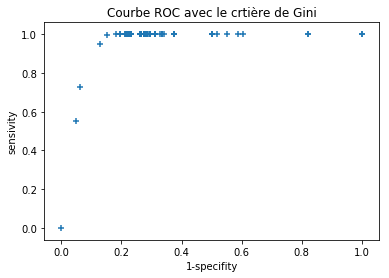

In [35]:
# Trace de la courbe ROC
sen = np.array(sen)
spe = np.array(spe)
plt.title('Courbe ROC avec le crtière de Gini')
plt.xlabel('1-specifity')
plt.ylabel('sensivity')
plt.scatter(1-spe,sen,marker='+')
# plt.plot(sen,spe)
plt.show()

Le poids des labels permet ici d'influencer soit la spécifité soit la sensivité du modèle. Le poids attribué au label sera donc choisi en fonction du critère de performance que l'on souhaite maximiser : si on veut maximiser le nombre de true_negative, il faudra un poids plus important sur les labels XX. Un poids équilibré permet un bon compromis entre les deux indicateurs de performances.

### Etude du critère pour l'élaboration des hypothèses

L'évaluation de l'impureté à chaque noeud se fait grâce à une fonction : on retrouve dans la littérature deux fonctions principalement : le critère de Gini et l'enthropie. Afin de comparer les performances entre ces deux critères, on peut déterminer la courbe ROC de chacun des modèles : le modèle le plus efficace est celui qui aura une sensivité et spécificité maximale et donc une aire sous la courbe maximale.

In [14]:
list_weight = list(range(0,101))
for i in [99.95,99.99,99.999]:
    list_weight.append(i)
    list_weight.append(100-i)
list_weight=sorted(list_weight)
nber_block = 50
print(nber_block*'-')
k=0

sens_gini,spec_gini,sens_entr,spec_entr = [],[],[],[]
list_perf = {"gini":[sens_gini,spec_gini],"entropy":[sens_entr,spec_entr]}
sen,spe=[],[]
for critere in list_perf.keys():
    for rate in list_weight:
        weight={+1:rate,-1:100-rate}
        clf = tree.DecisionTreeClassifier(criterion=critere, max_depth=5,random_state=1,class_weight=weight)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        sensivity,specifity,error1,error2,precision = stat_learning(y_test,y_pred)
        list_perf[critere][0].append(sensivity)
        list_perf[critere][1].append(specifity)
        progress(k,len(list_weight),nber_block)
        k+=1
    print('\n')

--------------------------------------------------
#

C:\Users\Kodjo\Desktop\Cours Machine Learning and Applications\projet\s\MALAP_Projet\tools.py:246: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(fp+tp)


#####################################################

#####################################################



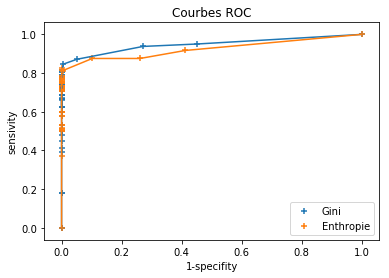

In [33]:
# Trace des courbes ROC
spec_gini = np.array(list_perf['gini'][0])
sens_gini = np.array(list_perf['gini'][1])
spec_entr = np.array(list_perf['entropy'][0])
sens_entr = np.array(list_perf['entropy'][1])
plt.scatter(1-spec_gini,sens_gini,marker='+')
plt.plot(1-spec_gini,sens_gini)
plt.scatter(1-spec_entr,sens_entr,marker='+')
plt.plot(1-spec_entr,sens_entr)
plt.xlabel('1-specifity')
plt.ylabel('sensivity')
plt.title('Courbes ROC')
plt.legend((gini,entropy),('Gini','Enthropie'),loc='lower right')
plt.show()

La courbe ROC du classifieur utilisant le critère d'enthropie a une aire sous la courbe inférieure à celle utilisant le critère de Gini. Cela est synonyme d'une meilleure du performance de l'arbre avec le critère de Gini ; en effet, à  poids égaux, le classifieur utilisant Gini a une sensiblité supérieure au second modèle mais une spécifité relativement identique.

### Autres critères à aborder ou non

Nombre de feuilles : min_sample_leaf et max_leaf_nodes
Nombre de features : max_features

### Conclusion

Parler de la méthode de sélection normalement (par validation croisée?). Comment mélanger tous les critères et choisir les bons?
Importance du temps de calcul qui a été déterminante ici (d'où la non-utilisation de validation croisée pour déterminer les divers paramères (1h30 pour kNN...)